In [1]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Activation
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn import model_selection
from sklearn import metrics
import time
import tensorflow as tf
import shap
import numpy as np
tf.compat.v1.disable_v2_behavior()

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
data = pd.read_csv('X-IIoTID dataset_processed.csv')

In [3]:
# load model
from keras.models import load_model
model = load_model('X-IIoTID_lstm_bin.h5')

2023-12-25 01:18:21.356036: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:375] MLIR V1 optimization pass is not enabled
2023-12-25 01:18:21.461538: W tensorflow/c/c_api.cc:304] Operation '{name:'lstm_5/lstm_cell/bias/Assign' id:395 op device:{requested: '', assigned: ''} def:{{{node lstm_5/lstm_cell/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](lstm_5/lstm_cell/bias, lstm_5/lstm_cell/bias/Initializer/concat)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-12-25 01:18:21.612773: W tensorflow/c/c_api.cc:304] Operation '{name:'dense_1/bias/m/Assign' id:746 op device:{requested: '', assigned: ''} def:{{{node dense_1/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_1/bias/m, dense

In [4]:
# Drop last 18 columns for X and remove class3
X = (data.iloc[:,:-18]).drop(columns = ['class3'], axis=1)
Y = data['class3']


from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state = 42)

# convert Y to int
Y_train = Y_train.astype(int)
Y_test = Y_test.astype(int)

# reshape the data for LSTM
X_train = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

# convert all to numpy arrays
X_train = np.asarray(X_train).astype(np.float32)
X_test = np.asarray(X_test).astype(np.float32)

In [5]:
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)
print('Classification Report')
print(metrics.classification_report(Y_test, y_pred))
print('Accuracy:')
print(metrics.accuracy_score(Y_test, y_pred))

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
2023-12-25 01:18:27.065003: W tensorflow/c/c_api.cc:304] Operation '{name:'dense_1/Sigmoid' id:553 op device:{requested: '', assigned: ''} def:{{{node dense_1/Sigmoid}} = Sigmoid[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_1/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Classification Report
              precision    recall  f1-score   support

           0       0.99      0.97      0.98     51897
           1       0.98      0.99      0.99     67311

    accuracy                           0.99    119208
   macro avg       0.99      0.98      0.98    119208
weighted avg       0.99      0.99      0.99    119208

Accuracy:
0.9852275015099657


In [6]:
import matplotlib.pyplot as plt
# tf.compat.v1.disable_v2_behavior()
tf.compat.v1.disable_eager_execution()

tf.compat.v1.disable_v2_behavior()
# # reset graph
# tf.compat.v1.reset_default_graph()

#  get keras session of the model
sess = tf.compat.v1.keras.backend.get_session()

# Create a DeepExplainer with Python lists
explainer = shap.DeepExplainer(model, X_train[:100], session=sess)

# Get Shapley values with Python lists
shap_values = explainer.shap_values(X_test[:10000])

# Rest of your code
shap.getjs()
shap.initjs()
features = X.columns.to_list()

# Use Python lists for force_plot
shap.force_plot(explainer.expected_value[0], shap_values[0][0], features)

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


93


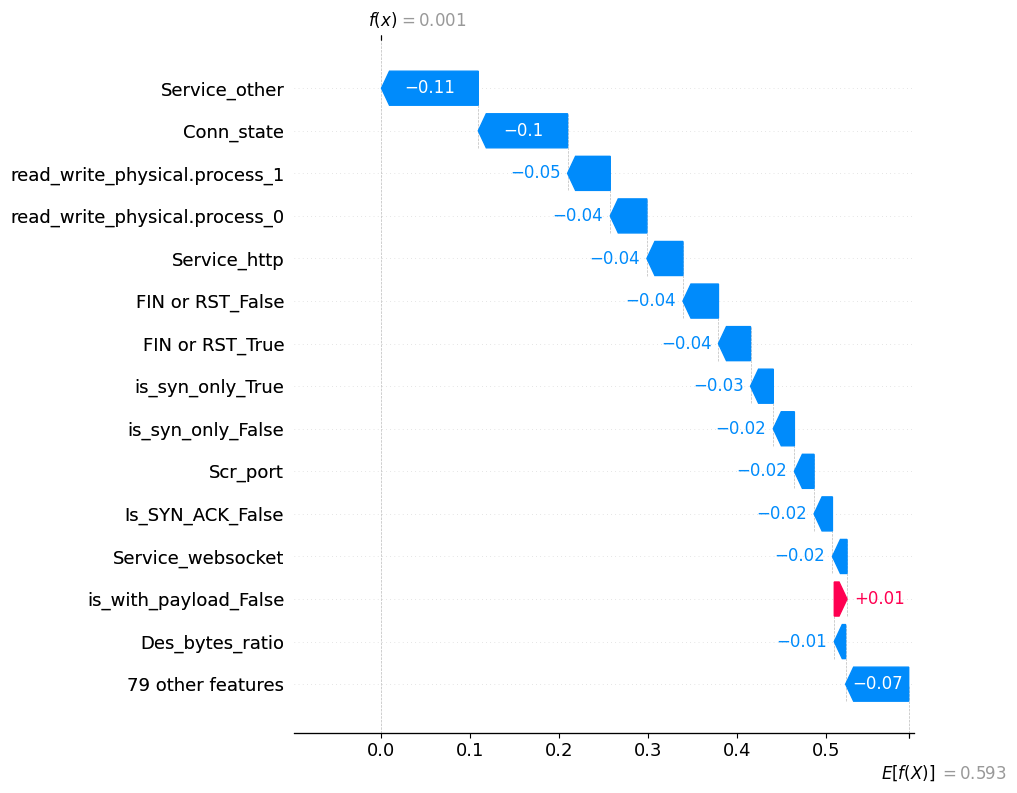

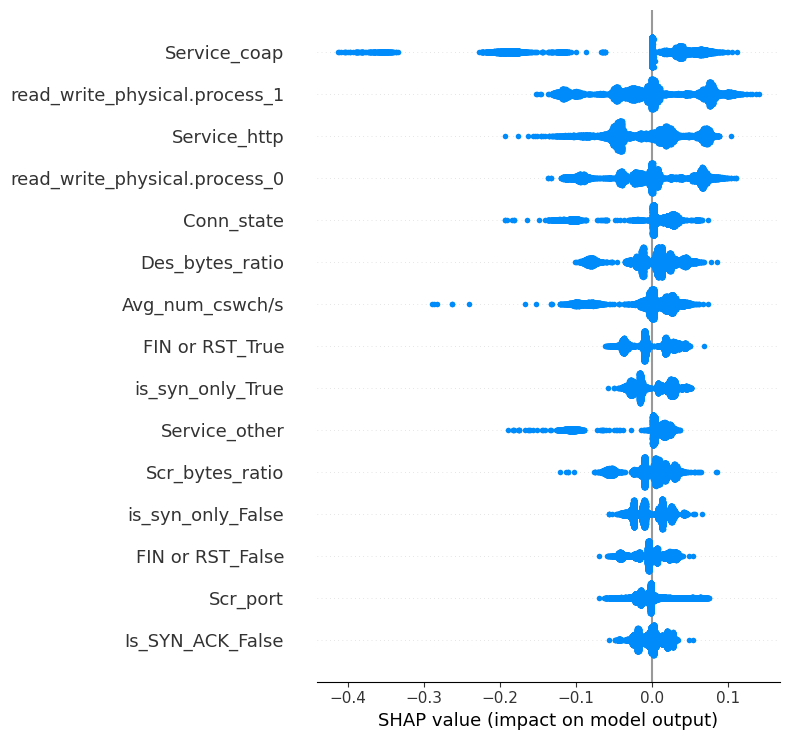

In [7]:
# display shap graph 
vals = shap_values[0]
# reshaping the values
vals = vals.reshape((vals.shape[0], vals.shape[2]))
print(len(vals[0]))
shap.waterfall_plot(shap.Explanation(values=vals[0], base_values=explainer.expected_value[0], feature_names=features), max_display = 15)
# shap.bar_plot(vals[0], feature_names=features, max_display=15)
shap.summary_plot(vals, feature_names=features, max_display=15)

In [8]:
# get top 15 features
top_15 = np.argsort(np.sum(np.abs(vals), axis=0))[-15:]
print(top_15)

# keep only top 15 features
data2 = data.copy()
data2 = data2.iloc[:,top_15]
data2['class3'] = data['class3']

[67  0 73 65 17 59 66 74 41 18  5 89 52 90 48]


In [9]:
#save data2
data2.to_csv('X-IIoTID dataset_processed_top15.csv')

In [10]:
data['class3']

0         0
1         1
2         1
3         1
4         1
         ..
596033    0
596034    1
596035    1
596036    0
596037    1
Name: class3, Length: 596038, dtype: int64

In [11]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn import metrics

# Drop last 18 columns for X and remove class3
X = (data2).drop(columns = ['class3'], axis=1)
Y = data2['class3']


from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state = 42)

# convert Y to int
Y_train = Y_train.astype(int)
Y_test = Y_test.astype(int)

# reshape the data for LSTM
X_train = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

# convert all to numpy arrays
X_train = np.asarray(X_train).astype(np.float32)
X_test = np.asarray(X_test).astype(np.float32)


# define the model
model = Sequential()
model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(64))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))

# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
start = time.time()
# train the model
history = model.fit(X_train, Y_train, epochs=10, batch_size=32, validation_data=(X_test, Y_test), shuffle=True)
end = time.time()
print("Time taken to train the model: ", end - start)

Train on 476830 samples, validate on 119208 samples
Epoch 1/10


2023-12-25 01:19:10.913729: W tensorflow/c/c_api.cc:304] Operation '{name:'lstm_1/lstm_cell/recurrent_kernel/Assign' id:2545 op device:{requested: '', assigned: ''} def:{{{node lstm_1/lstm_cell/recurrent_kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](lstm_1/lstm_cell/recurrent_kernel, lstm_1/lstm_cell/recurrent_kernel/Initializer/mul_1)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


476480/476830 [============================>.] - ETA: 0s - loss: 0.1455 - acc: 0.9539

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
2023-12-25 01:19:34.837399: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_1/mul' id:2945 op device:{requested: '', assigned: ''} def:{{{node loss_1/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_1/mul/x, loss_1/dense_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


476830/476830 [==============================] - 26s 54us/sample - loss: 0.1455 - acc: 0.9539 - val_loss: 0.0912 - val_acc: 0.9655
Epoch 2/10
476830/476830 [==============================] - 24s 51us/sample - loss: 0.0906 - acc: 0.9690 - val_loss: 0.0808 - val_acc: 0.9728
Epoch 3/10
476830/476830 [==============================] - 24s 51us/sample - loss: 0.0837 - acc: 0.9717 - val_loss: 0.0760 - val_acc: 0.9754
Epoch 4/10
476830/476830 [==============================] - 24s 50us/sample - loss: 0.0807 - acc: 0.9728 - val_loss: 0.0722 - val_acc: 0.9762
Epoch 5/10
476830/476830 [==============================] - 25s 52us/sample - loss: 0.0779 - acc: 0.9733 - val_loss: 0.0703 - val_acc: 0.9762
Epoch 6/10
476830/476830 [==============================] - 24s 51us/sample - loss: 0.0760 - acc: 0.9736 - val_loss: 0.0766 - val_acc: 0.9727
Epoch 7/10
476830/476830 [==============================] - 24s 50us/sample - loss: 0.0747 - acc: 0.9737 - val_loss: 0.0653 - val_acc: 0.9766
Epoch 8/10
476830

In [14]:
start = time.time()
y_pred = model.predict(X_test)
end = time.time()
y_pred = (y_pred > 0.5)
print('Classification Report')
print(metrics.classification_report(Y_test, y_pred))
print('Accuracy:')
print(metrics.accuracy_score(Y_test, y_pred))
print("Time taken to predict: ", end - start)

Classification Report
              precision    recall  f1-score   support

           0       0.99      0.96      0.97     51897
           1       0.97      0.99      0.98     67311

    accuracy                           0.98    119208
   macro avg       0.98      0.97      0.98    119208
weighted avg       0.98      0.98      0.98    119208

Accuracy:
0.9766374739950339
Time taken to predict:  1.3665668964385986
